# cs8321 Lab 2 - Transfer Learning and Transformers

#### Chip Henderson - 48996654

## [2.0 points] Dataset Overview

In this dataset, I'll be working on a sentiment classification. This is a many to one classifier of Amazon reviews. I'll be working with categories of negative, netral, and positive.

Thhis version of the Amazon reviews dataset is was updated in 2018 from an original version in 2014. It consists of more than 230 million customer reviews from 1996 to 2018.

**What is the feature data? Who collected the data? Why? When? Is it multimodal?**

**What evaluation criteria will you be using, why?**

## [2.0 points] Describe the foundational model that you will be using to transfer learn from

I'll be using the bert-base-uncased model for my foundation model. This model's architecture consists of:
* 12 layers
* 768 hidden
* 12-heads
* 110 million parameters

and trained on lower-cased English text per the [hugging face repo](https://huggingface.co/transformers/v3.3.1/pretrained_models.html).

**What tasks was the foundational model trained from?**

Per the hugging face [blog site](https://huggingface.co/google-bert/bert-base-uncased?text=The+goal+of+a+dog%27s+life+is+%5BMASK%5D), "the BERT model was pretrained on BookCorpus, a dataset consisting of 11,038 unpublished books and English Wikipedia. It is also known as the Toronto Book Corpus, and consists of the text of around 7,000 self-published books scraped from the indie ebook distribution website Smashwords [per wikipedia](https://en.wikipedia.org/wiki/BookCorpus). The dataset consists of around 985 million words across a large span of genres.

**Explain if the new task is within the same domain, across domains, etc.**

## [1.0 points] Split the data into training and testing

We'll start by importing the data from the source. I'll use a pandas dataframe initially due to its ease of understanding the labels and data types in the dataset.

In [2]:
# Uncomment for use in colab
from google.colab import drive
drive.mount('/content/drive/')

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
%%time
# Source: modified from https://nijianmo.github.io/amazon/index.html for
# importing data. Customized path and df name
import pandas as pd
import gzip
import json

# path = "../Data_sources/Electronics_5.json.gz" # local
path = "/content/drive/MyDrive/Colab Notebooks/Data_sources/Electronics_5.json.gz" # colab

def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield json.loads(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

init_df = getDF(path)


CPU times: user 2min 14s, sys: 16.2 s, total: 2min 30s
Wall time: 2min 30s


In [ ]:
init_df.head()

,overall,vote,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,image
0,5.0,67,True,"09 18, 1999",AAP7PPBU72QFM,0151004714,{'Format:': ' Hardcover'},D. C. Carrad,This is the best novel I have read in 2 or 3 y...,A star is born,937612800,NaN
1,3.0,5,True,"10 23, 2013",A2E168DTVGE6SV,0151004714,{'Format:': ' Kindle Edition'},Evy,"Pages and pages of introspection, in the style...",A stream of consciousness novel,1382486400,NaN
2,5.0,4,False,"09 2, 2008",A1ER5AYS3FQ9O3,0151004714,{'Format:': ' Paperback'},Kcorn,This is the kind of novel to read when you hav...,I'm a huge fan of the author and this one did ...,1220313600,NaN
3,5.0,13,False,"09 4, 2000",A1T17LMQABMBN5,0151004714,{'Format:': ' Hardcover'},Caf Girl Writes,What gorgeous language! What an incredible wri...,The most beautiful book I have ever read!,968025600,NaN
4,3.0,8,True,"02 4, 2000",A3QHJ0FXK33OBE,0151004714,{'Format:': ' Hardcover'},W. Shane Schmidt,I was taken in by reviews that compared this b...,A dissenting view--In part.,949622400,NaN


### Dimensionality Reduction

This is a big dataset, and there are a number of columns I don't need. To keep operations faster I'm going to drop everything I don't need.

In [ ]:
features_to_keep = ['overall','reviewText']
features_to_drop = [feature for feature in init_df.columns if feature not in features_to_keep]
df = init_df.drop(features_to_drop,axis=1)

del init_df # memory management
df.head()

,overall,reviewText
0,5.0,This is the best novel I have read in 2 or 3 y...
1,3.0,"Pages and pages of introspection, in the style..."
2,5.0,This is the kind of novel to read when you hav...
3,5.0,What gorgeous language! What an incredible wri...
4,3.0,I was taken in by reviews that compared this b...


In [ ]:
df = df.sample(frac=0.01,replace=False) # local
# Colab could run 5% of the data but it completely maxed out the 51 GB of RAM
# df = df.sample(frac=0.05,replace=False) # colab
df.reset_index(drop=True,inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67396 entries, 0 to 67395
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   overall     67396 non-null  float64
 1   reviewText  67379 non-null  object 
dtypes: float64(1), object(1)
memory usage: 1.0+ MB


I'm also going to remove any stop words from the review text. Stop words are words like "a,” “the,” “is,” “are," and don't add a lot of contextual value. So they're a good way to reduce the size of the reviews. Before I can do that I need to make sure there aren't any unrecognized characters so I'll do some additional processing on the review text.

In [ ]:
# Note: Built in pandas functionality didn't seem to
df['reviewText'] = df['reviewText'].str.strip()
# df['str_reviewText'] = df['reviewText'].apply(lambda x: str(x)) # source ChatGPT
df['str_reviewText'] = df['reviewText'].astype(str)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67396 entries, 0 to 67395
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   overall         67396 non-null  float64
 1   reviewText      67379 non-null  object 
 2   str_reviewText  67396 non-null  object 
dtypes: float64(1), object(2)
memory usage: 1.5+ MB


In [ ]:
%%time
# Use NLTK to remove stopwords
import nltk
# import re
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = set(stopwords.words("english"))

def remove_stop_words(review):
    # no_tags = re.sub(pattern,'',tweet)
    no_stop_words = [word for word in review.split() if word not in stop_words]
    return ' '.join(no_stop_words)


# Apply the pattern to remove those tags from tweets
df['str_reviewText'] = df['str_reviewText'].apply(remove_stop_words)

print(df['str_reviewText'])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


0                                 Perfect case GoPro stuff
1        Super easy set up---there really set time besi...
2                                                     Good
3        I purchased Samsung 6050 Smart LED 1080HD...th...
4        It charges GoPro Hero 3 Hero 3+ batteries (bec...
                               ...                        
67391    First - image SUPER clear andLARGE enough actu...
67392    I extremely happy camera. I use GSXR-1000 twis...
67393    This 5000mAh battery Red Dot winning design te...
67394               really pleased I ordered 16gb got 32gb
67395    I installed total 6 Nest products. One thermos...
Name: str_reviewText, Length: 67396, dtype: object
CPU times: user 1.57 s, sys: 889 ms, total: 2.46 s
Wall time: 2.58 s


Strangely, these don't all seem like electronics reviews...but for my purposes it really doesn't matter. Also, there's no obvious sentiment labels in the dataset. So I'm going to use the overall rating as my sentiments. I'll set up the following categories:
 -  0-2: Negative
 -  3: Neutral
 -  4-5: Positive

After grouping, I'll plot the distributions using a pie chart to visually observe how many samples are in each group.

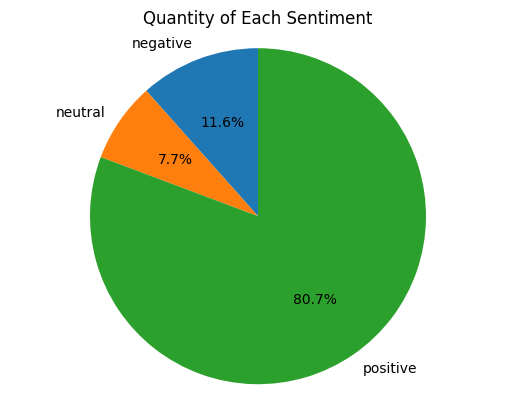

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

# Bracket the sentiments based on Overall value
df['sentiment'] = pd.cut(df['overall'], [0,2,3,5], labels=['negative','neutral','positive'])

# Group the data by sentiment for purposes of charting
sentiments = df.groupby(['sentiment'])
pie_data = sentiments.size()

# Set the pie chart parameters
plt.pie(pie_data, labels=pie_data.index, autopct='%1.1f%%', labeldistance=1.1, startangle=90)

plt.title("Quantity of Each Sentiment")
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

# Get the exact count of each value to provide further information
df.value_counts(['sentiment'])

del sentiments # memory management

There is a significant misbalance of my classes, so I'm going to need to make sure I stratify the data so that the data is well represented. Before I do that, I'll tokenize the reviews and and prepare the data for splitting by narrowing down to fields of interest.

To get started with tokenizing, I need to know the max length I'll encounter in the reviews.

In [ ]:
# Determine longest review length
print(f"The longest review is {len(max(df['str_reviewText'], key=len))} characters")

The longest review is 14254 characters


In order for all the data going into the model to be same length, I'll need to zero-pad the sequences. For data consistency, I want all reviews to have some zero-padding. If my longest review length is 26,673 characters, I'll round up to 26,680 for my max length.

In [ ]:
%%time
# Source: cs7324 lab 7
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

NUM_TOP_WORDS = None # use entire vocabulary!
MAX_REVIEW_LEN = 26680  # maximum and minimum number of words

#tokenize the text
tokenizer = Tokenizer(num_words=NUM_TOP_WORDS)
tokenizer.fit_on_texts(df['str_reviewText'])
# save as sequences with integers replacing words
sequences = tokenizer.texts_to_sequences(df['str_reviewText'])

word_index = tokenizer.word_index
NUM_TOP_WORDS = len(word_index) if NUM_TOP_WORDS==None else NUM_TOP_WORDS
top_words = min((len(word_index),NUM_TOP_WORDS))
print('Found %s unique tokens. Distilled to %d top words.' % (len(word_index),top_words))

X = pad_sequences(sequences, maxlen=MAX_REVIEW_LEN)
y = df.sentiment.values
print('Shape of data tensor:', X.shape)
print('Shape of label tensor:', y.shape)
print(np.max(X))


Found 52270 unique tokens. Distilled to 52270 top words.
Shape of data tensor: (67396, 26680)
Shape of label tensor: (67396,)
52270
CPU times: user 7.41 s, sys: 1.82 s, total: 9.23 s
Wall time: 11.6 s


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, test_size=0.2, stratify=y)

In [ ]:
# Source: in class lecture notebook cs7324 13a

from sklearn.preprocessing import LabelEncoder
from tensorflow import keras

# Use label encoder to get my data into integer form
label_encoder = LabelEncoder()
y_enc_train = label_encoder.fit_transform(y_train)
y_enc_test = label_encoder.fit_transform(y_test)

# One-hot encode the encoded labels
y_train_ohe = keras.utils.to_categorical(y_enc_train)
y_test_ohe = keras.utils.to_categorical(y_enc_test)

# Check the shape of the data and labels to ensure they are correct
print('Shape of data tensor train:', X_train.shape)
print('Shape of data tensor for test:', X_test.shape)
print('Shape of label tensor train:', y_train_ohe.shape)
print('Shape of label tensor for test:', y_test_ohe.shape)

Shape of data tensor train: (53916, 26680)
Shape of data tensor for test: (13480, 26680)
Shape of label tensor train: (53916, 3)
Shape of label tensor for test: (13480, 3)


**explain how you performed this operation and why you think it is reasonable to split this particular dataset this way**

**For multi-task datasets, be sure to explain if it is appropriate to stratify within each task.**

**If the dataset is already split for you, explain how the split was achieved and how it is stratified.**

## [2.0 points] Train a model from scratch to perform the classification task (this does NOT need to be a transformer).

**Verify the model converges (even if the model is overfit).**

#### Convolutional Neural Network 1 (CNN-1)

The first CNN I'll run will consist of 64 filters with a width of 5. I'm changing the filter size from the in-class example because my dataset is quite a bit smaller. So my thought being I won't need so many filters to get good results.

In [ ]:
%%time
# Source: Modified from in-class lecture notebook 13a
EMBED_SIZE = 300
# the embed size should match the file you load glove from
embeddings_index = {}
# f = open(r'C:\Users\Chip\source\repos\cs7324_code\Data_Sources\glove.6B\glove.6B.50d.txt')
f = open(r'/content/drive/MyDrive/Colab Notebooks/Data_sources/glove.6B.300d.txt') # colab
# save key/array pairs of the embeddings
#  the key of the dictionary is the word, the array is the embedding
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

# now fill in the matrix, using the ordering from the
#  keras word tokenizer from before
found_words = 0
embedding_matrix = np.zeros((len(word_index) + 1, EMBED_SIZE))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be ALL-ZEROS
        embedding_matrix[i] = embedding_vector
        found_words = found_words+1

print("Embedding Shape:",embedding_matrix.shape, "\n",
      "Total words found:",found_words, "\n",
      "Percentage:",100*found_words/embedding_matrix.shape[0])

Found 400000 word vectors.
Embedding Shape: (52271, 300) 
 Total words found: 31075 
 Percentage: 59.44979051481701
CPU times: user 22.9 s, sys: 863 ms, total: 23.7 s
Wall time: 23.6 s


In [ ]:
# Source: Modified from in-class notebook 13a
# save this embedding now
from tensorflow.keras.layers import Embedding, Input, Concatenate
embedding_layer = Embedding(len(word_index) + 1,
                            EMBED_SIZE,
                            weights=[embedding_matrix],# here is the embedding getting saved
                            input_length=MAX_REVIEW_LEN,
                            trainable=False)

In [ ]:
if False:
        # Source: Modified from in-class lecture, cs7324, notebook 13a
        from tensorflow.keras.metrics import Precision
        from tensorflow.keras.models import Model
        from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D
        from tensorflow.keras.layers import Flatten, Dense, Dropout


        EMBED_SIZE = 300  # same size as loaded from GLOVE
        NUM_CLASSES = 3
        sequence_input = Input(shape=(MAX_REVIEW_LEN,), dtype='int32')
        # starting size: 500
        embedded_sequences = embedding_layer(sequence_input) # from previous embedding
        x = Conv1D(64, 5, activation='relu',
                kernel_initializer='he_uniform')(embedded_sequences)

        # after conv, size becomes: 500-4=496
        x = MaxPooling1D(5)(x) # after max pool, 996/5 = 99
        x = Dropout(0.2)(x) # after dropout, size is 95
        x = Conv1D(64, 5, activation='relu',
                kernel_initializer='he_uniform')(x)

        # new size is 195
        x = MaxPooling1D(5)(x) # after max pool, size is 95/5 = 19
        x = Dropout(0.2)(x)
        x = Conv1D(64, 5, activation='relu',
                kernel_initializer='he_uniform')(x)

        # after convolution, size becomes 15 elements long
        x = MaxPooling1D(5)(x) # this is the size to globally flatten, 15/5 = 3
        # flattened vector max pools across each of the 3 elements
        # so vectors is now 192 dimensions 3*64 = 192
        x = Flatten()(x)

        x = Dropout(0.2)(x)
        x = Dense(64, activation='relu',
                kernel_initializer='he_uniform')(x)

        preds = Dense(NUM_CLASSES, activation='softmax',
                kernel_initializer='glorot_uniform')(x)

        model_cnn_1 = Model(sequence_input, preds)

        # if representing as OHE, use categorical_crossentropy
        # if representing the class as an integer, use sparse_categorical_crossentropy
        model_cnn_1.compile(loss='categorical_crossentropy',
                optimizer='rmsprop',
                metrics=['Precision'])

        print(model_cnn_1.summary())

        cnn1_histories = []
        tmp = model_cnn_1.fit(X_train, y_train_ohe, validation_data=(X_test, y_test_ohe),
                epochs=30, batch_size=128)
        cnn1_histories.append(tmp)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 26680)]           0         
                                                                 
 embedding (Embedding)       (None, 26680, 300)        15681300  
                                                                 
 conv1d (Conv1D)             (None, 26676, 64)         96064     
                                                                 
 max_pooling1d (MaxPooling1  (None, 5335, 64)          0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 5335, 64)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 5331, 64)          20544     
                                                             

In [ ]:
# Source: Modified from in class notebook 13a

EMBED_SIZE = 300  # same size as loaded from GLOVE
sequence_input = Input(shape=(MAX_TWEET_LEN,), dtype='int32')
# starting size: 1000
embedded_sequences = embedding_layer(sequence_input) # from previous embedding
x = Conv1D(64, 5, activation='relu',
           kernel_initializer='he_uniform')(embedded_sequences)

# after conv, size becomes: 1000-4=996
x = MaxPooling1D(5)(x)# after max pool, 996/5 = 199
x = Dropout(0.2)(x)
x = Conv1D(64, 5, activation='relu',
           kernel_initializer='he_uniform')(x)

# new size is 195
x = MaxPooling1D(5)(x) # after max pool, size is 195/5 = 39
x = Dropout(0.2)(x)
x = Conv1D(64, 5, activation='relu',
           kernel_initializer='he_uniform')(x)

# after convolution, size becomes 15 elements long
# Take the mean of these elements across features, result is 128 elements
x_mean = GlobalAveragePooling1D()(x) # this is the size to globally flatten 

# Take the variance of these elements across features, result is 128 elements
x_tmp = Subtract()([x,x_mean])
x_std = GlobalAveragePooling1D()(x_tmp**2)

x = Concatenate(name='concat_1')([x_mean,x_std])


x = Dense(64, activation='relu',
          kernel_initializer='he_uniform')(x)

x = Dropout(0.2)(x)

preds = Dense(NUM_CLASSES, activation='softmax',
              kernel_initializer='glorot_uniform')(x)

model_xvec = Model(sequence_input, preds)

# if representing as OHE, use categorical_crossentropy
# if representing the class as an integer, use sparse_categorical_crossentropy
model_xvec.compile(loss='categorical_crossentropy', 
              optimizer='adam',
              metrics=['Precision'])

print(model_xvec.summary())

model_xvec_histories = []
tmp = model_xvec.fit(X_train, y_train_ohe, validation_data=(X_test, y_test_ohe),
          epochs=10, batch_size=128)
model_xvec_histories.append(tmp)

NameError: name 'Input' is not defined

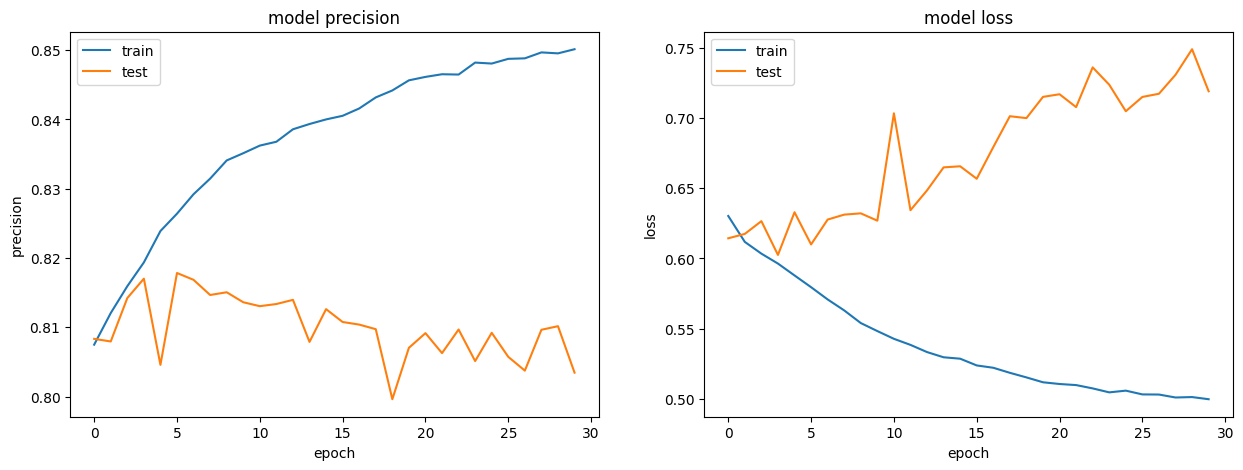

In [ ]:
# Source: in class lecture notebook 13a
%matplotlib inline

# combine all the history from training together
combined = dict()
for key in ['precision','val_precision','loss','val_loss']:
    combined[key] = np.hstack([x.history[key] for x in cnn1_histories])

# summarize history for precision
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(combined['precision'])
plt.plot(combined['val_precision'])
plt.title('model precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# summarize history for loss
plt.subplot(122)
plt.plot(combined['loss'])
plt.plot(combined['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## [2.0 points] Transfer Learning

In [ ]:
%time
from transformers import BertTokenizer, TFBertModel

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 8.11 µs


**Train a model by transfer learning from your foundational model.**

**Verify that the new model converges. You only need to train a model using the bottleneck features for this step.**

## [2.0 points] Fine Tuning

**Perform fine tuning upon the model by training some layers within the foundational model**

**Verify that the model converges.**

## [4.0 points] Report the results

**Report the results of all models using the evaluation procedure that you argued for at the beginning of the lab.**

**Compare the convergence of the models and the running time.**

**Results should be reported with proper statistical comparisons and proper visualizations.**

## Sources

In [ ]:
https://keras.io/examples/nlp/pretraining_BERT/
https://www.smashwords.com/about
https://huggingface.co/google-bert/bert-base-uncased?text=The+goal+of+a+dog%27s+life+is+%5BMASK%5D.
https://keras.io/guides/keras_nlp/transformer_pretraining/
https://huggingface.co/transformers/v3.3.1/pretrained_models.html
https://www.analyticsvidhya.com/blog/2021/05/all-you-need-to-know-about-bert/#:~:text=The%20BERTBase%20model%20uses,has%20around%20110M%20trainable%20parameters.

SyntaxError: invalid decimal literal (<ipython-input-17-0ead7cd09a2c>, line 3)